In [35]:
using CSV, DataFrames, Random, LinearAlgebra, Distances, Distributions, SpecialFunctions, Plots

#Single population model

#Each timestep, following processes are simulated in a given sequence
#1. Mortality of adults due to selection- Prob of death= (exp((T-T(opt))^2)/sigma)
#2. Reproduction-Mating between different genotypes represented by Barton's hypergeometric model
#3. Settlement- density dependent removal of newly produced larvae 

#Quantitative genetic model: 
#the 'heat tolerence' trait is determined by a total of L bialleilic loci, where allele "0" means
#unfavorable trait for temp. tolerence. All loci contribute independently (no linkage) and 
#equally. Therefore, the trait value of an individual is simply assumed to be the sum of all "1"
#alleles present in an individual. Approx. hypergeometric model for diploids is used 
#to describe the effect of evolutionary processes on trait propagation (barton 1992).

#Reproduction: a)Mating: A fraction of the population is assumed to reproduce asexually. The 
#rest of the population is assumed to start the mating process simultaneously where they 
#release their gametes in a pool and random mating is assumed to occur.

#Model parameters

#no. of loci
#n=114
#pheno= collect(1:(2*n+1))
#nt=length(pheno)
#Growth rate
#r=1.38
#Carrying capacity
#K=1000
#Proportion of asexually reproducing individuals
#pa=0.6

#Create a function to simulate pop dynamic 
function singlepop(n::Int64,r::Float64,K::Float64,pa::Float64,SST::Vector{Float64},tstep::Int64)
    
    pheno= collect(1:(2*n+1)) ./ (2*n+1)
    nt=length(pheno)

    #Precalculate the probabilities of getting an offspring with trait k when the gametes with 'trait 
    #value' i an j are combined

    G=zeros(Float64,n+1,n+1,n+1)

    for i in 0:n, j in 0:i, k in max(0,(i+j-n)):min(n,(i+j))
                m=collect(0:min(j,k,i+j-k))
                G[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),m).*pdf.(Binomial.(i+j .- (2 .* m)),k .- m))
    end

    for k in 0:n
        G[:,:,1+k]=G[:,:,1+k]+transpose(G[:,:,1+k])
        for i1 in 0:n
            G[i1+1,i1+1,k+1] /= 2
        end
    end

    ind_haplR=zeros(Float64,2*n+1, 2*n+1)

    for k in 0:n
        for i in 0:n
             ind_haplR[1+i,1+k] = G[1+i,1,1+k]
            for j in 0:n
                ind_haplR[1+j+n,1+k]=G[1+n,1+j,1+k]
            end
        end
    end

    R=zeros(Float64,nt,nt,nt)

    for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
         R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                             ind_haplR[1+j,1+q .- (0:q)])
    end

    #Start the simulation
        
    res=zeros(Float64,tstep+1,nt)

    N=rand(Uniform(0,1.0),nt)
    Ng0= N ./ sum(N)
    Np0= 950 .* Ng0 

    Ngen=deepcopy(Ng0)
    Np=deepcopy(Np0)
        
    topt1=sum(pheno .* Np0)/ sum(Np0)
        
    topts=topt1 .+ (1.2 .* SST)  
        
    res[1,:]=Np

    for t in 1:tstep

            topt=topts[t]

            #Selection event

                probsurv=exp.(-((topt .-pheno) .^2) ./ 0.16)
                Np=Np.*probsurv

            #Reproduction event

            if(pa<1)

                newgen=zeros(Float64,nt)        

                probs=Ngen*Ngen'

                for i in 1:length(Ngen)

                    newgen[i]=sum(probs.*R[:,:,i])
                end

                Np=((pa*sum(Np)) .* Ngen) + (((1-pa)*sum(Np)) .* newgen)

                Ngen=Np/sum(Np)

            end

            #Settlement

            Np=(sum(Np)+ (r*sum(Np)*(1-(sum(Np)/K)))) .* Ngen 

            Ngen=Np ./sum(Np)
            
            res[t+1,:]=Np

    end 
    
    return res
end
    

singlepop (generic function with 1 method)

In [55]:

#no. of loci
n=114
pheno= collect(1:(2*n+1))
nt=length(pheno)

#Growth rate
r=1.38
#Carrying capacity
K=1000.0
#Proportion of asexually reproducing individuals
pa=0.0

# Four temperature warming scenarios for red sea under (GFDL-CM3 model Shaltout 2019, Oceanologia
#Fig. 13)
SSTs=DataFrame(rcp2_6=collect(range(start=0,stop=0.775, length=95)),
              rcp4_5=collect(range(start=0,stop=1.6, length=95)),
              rcp6_0=collect(range(start=0,stop=1.925, length=95)),
              rcp8_5=collect(range(start=0,stop=3.0, length=95)))

tsteps=size(SSTs)[1]

resdat=zeros(Float64,length(names(SSTs)),tsteps+1,nt)

for i in 1:length(names(SSTs))
            
        res=singlepop(n,r,K,pa,SSTs[:,i],tsteps)
        resdat[i,:,:]=res
        
end

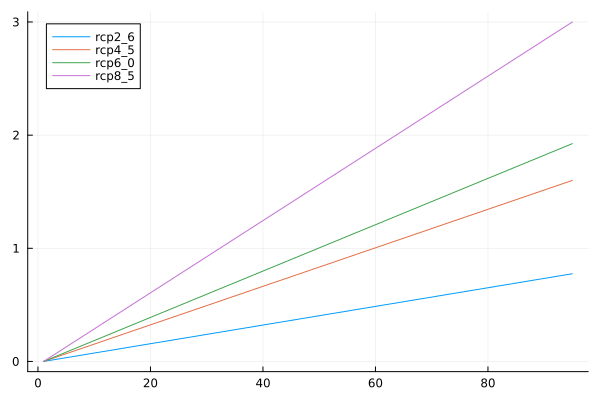

In [31]:
Plots.plot(SSTs[:,1],label=names(SSTs)[1])
Plots.plot!(SSTs[:,2],label=names(SSTs)[2])
Plots.plot!(SSTs[:,3],label=names(SSTs)[3])
Plots.plot!(SSTs[:,4],label=names(SSTs)[4])


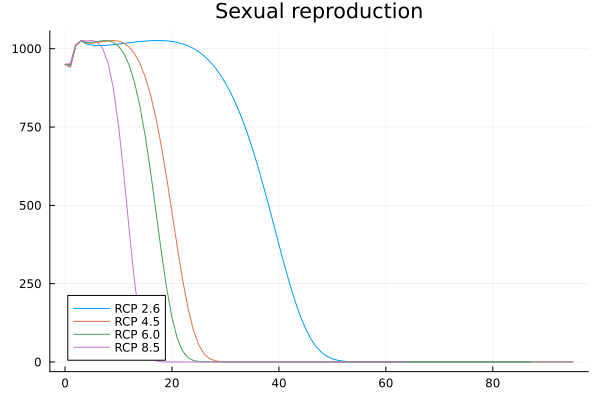

In [56]:
resdat1=DataFrame()

        
for i in 1:length(names(SSTs))
    
    append!(resdat1,DataFrame(scenario=names(SSTs)[i],time=collect(0:tsteps),N=sum(eachcol(resdat[i,:,:]))))
            
end

resdat_a=resdat1[resdat1.scenario .== "rcp2_6",:]

myplot1=Plots.plot(resdat_a.time,resdat_a.N, title="Sexual reproduction", label="RCP 2.6")

resdat_a=resdat1[resdat1.scenario .== "rcp4_5",:]
Plots.plot!(resdat_a.time,resdat_a.N, label="RCP 4.5")

resdat_a=resdat1[resdat1.scenario .== "rcp6_0",:]
Plots.plot!(resdat_a.time,resdat_a.N, label="RCP 6.0")

resdat_a=resdat1[resdat1.scenario .== "rcp8_5",:]
Plots.plot!(resdat_a.time,resdat_a.N, label="RCP 8.5")


In [57]:
savefig("singlepop1.png")

"C:\\Users\\mihir\\singlepop1.png"

In [ ]:
#Look at two results:
#1. How the population size changes over time
#2. How the trait distribution changes over time.

xs=collect(1:nt)

res=resdat[1,:,:]

anim=@animate for i ∈ 1:77
    Plots.plot(xs, res[i,:])
end
gif(anim,fps=5)


In [ ]:
#Spatially explicit metapopulation version of the model

#Model parameters
#Define the parameters (except for genetic information) for each of the subpopulation

#no. of loci
n=114
geno= collect(1:(2*n+1))
nt=length(geno)

#No. subpopulations
npops=10

#Growth rate
r=repeat([1.38],npops)

#Carrying capacity
K=repeat([1000],npops)

#Proportion of asexually reproducing individuals
pa=0.6

#Migration matrix NpopsXNpops: Indicates the proportion of the population migrating
#from pop i to pop j
mmat=ones(Float64,npops,npops)
#The matrix can be customised with empirical data
#For now, let us assume that the matrix has identical Aij (i not equal to j)values and 
#total of 10% of the each population emigrates.
mmat=mmat/((npops-1)*10)
[mmat[x,x]=0 for x in 1:3]


#Precalculate the probabilities of getting an offspring with trait k when the gametes with 'trait 
#value' i an j are combined

G=zeros(Float64,n+1,n+1,n+1)

for i in 0:n, j in 0:i, k in max(0,(i+j-n)):min(n,(i+j))
            m=collect(0:min(j,k,i+j-k))
            G[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),m).*pdf.(Binomial.(i+j .- (2 .* m)),k .- m))
end
    
for k in 0:n
    G[:,:,1+k]=G[:,:,1+k]+transpose(G[:,:,1+k])
    for i1 in 0:n
        G[i1+1,i1+1,k+1] /= 2
    end
end
    
ind_haplR=zeros(Float64,2*n+1, 2*n+1)

for k in 0:n
    for i in 0:n
         ind_haplR[1+i,1+k] = G[1+i,1,1+k]
        for j in 0:n
            ind_haplR[1+j+n,1+k]=G[1+n,1+j,1+k]
        end
    end
end

R=zeros(Float64,nt,nt,nt)

for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
     R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                         ind_haplR[1+j,1+q .- (0:q)])
end
    

#Start the simulation
    
res=zeros(78,npops,nt)    
    
N=rand(Uniform(0,1.0),npops,nt)
Ng0= N ./ sum(eachcol(N))
Np0= 950 .* Ng0 
    
Ngen=deepcopy(Ng0)
Np=deepcopy(Np0)

res[1,:,:]=Np    
 
#Some token trend of changes in optimal trait with time.    
topts=collect(range(100,stop=135,length=77))
    
for t in 1:77
                
        topt=topts[t]
        
        #Selection event
            
            probsurv=exp.(-((topt .-geno) .^2) ./ 500)
            Np=Np .* probsurv'
            
        #Reproduction event
        
        if(pa<1)
            
            newgen=zeros(Float64,npops,nt)
            
            for i in 1:size(Ngen)[1]
                
                probs=Ngen[i,:]*(Ngen[i,:]')
                
                for j in 1:size(Ngen)[2]
                    
                    newgen[i,j]=sum(probs.*R[:,:,i])
                end
                
                Np[i,:]=((pa*sum(Np[i,:])) .* Ngen[i,:]) + (((1-pa)*sum(Np[i,:])) .* newgen[i,:])
                
                Ngen[i,:]=Np[i,:]/sum(Np[i,:])
                
            end
        
        #Settlement
            
        for i in 1:size(Np)[1]
                
            Np[i,:]=(sum(Np[i,:])+ (r[i]*sum(Np[i,:])*(1-(sum(Np[i,:])/K[i])))) .* Ngen[i,:] 
        
            Ngen[i,:]=Np[i,:] ./sum(Np[i,:])

            res[t+1,:,:]=Np
        end
            
        #Migration
        
end
        



In [ ]:
N=rand(Uniform(0,1.0),npops,nt)

Ng0=N ./sum(eachcol(N))

In [ ]:
probsurv=exp.(-((topts[1] .-geno) .^2) ./ 500)

In [ ]:
res=zeros(78,npops,nt)    
    
N=rand(Uniform(0,1.0),npops,nt)
Ng0= N ./ sum(eachcol(N))
Np0= 950 .* Ng0 
    
Ngen=deepcopy(Ng0)
Np=deepcopy(Np0)

Np
    